In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [15]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [16]:
!pwd

/content/drive/My Drive/Kaggle


In [17]:
#!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

In [18]:
#!unzip \*.zip  && rm *.zip

In [19]:
import pandas as pd
import numpy as np
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from matplotlib.image import imread
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator


print("Pandas Version %s" %pd.__version__)
print("Numpy version %s" % np.__version__)
print("Tensorflow Version %s" % tf.__version__)
print("CV Version %s" % cv.__version__)

Pandas Version 1.1.5
Numpy version 1.19.5
Tensorflow Version 2.4.1
CV Version 4.1.2


In [20]:
# Take A look To data
print("Train Covid " ,len(os.listdir("/content/drive/My Drive/Kaggle/Data/train/COVID19/")))
print("Train normal", len(os.listdir("/content/drive/My Drive/Kaggle/Data/train/NORMAL//")))

print("Test Covid", len(os.listdir("/content/drive/My Drive/Kaggle/Data/test/COVID19/")))
print("Test Normal", len(os.listdir("/content/drive/My Drive/Kaggle/Data/test/NORMAL/")))





Train Covid  460
Train normal 1266
Test Covid 116
Test Normal 317


In [21]:
TRAININGXRAY = "/content/drive/My Drive/Kaggle/Data/train/"
TESTXRAY = "/content/drive/My Drive/Kaggle/Data/test/"


strategy = tf.distribute.MirroredStrategy()
print("Number of devices %d" %(strategy.num_replicas_in_sync))
BATCH_PER_REPLICA = 32 
BATCH_SIZE = BATCH_PER_REPLICA * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices 1


In [22]:
data = "/content/drive/My Drive/Kaggle/Data/train/COVID19/COVID19(0).jpg"
cv.imread(data).shape

(2000, 2000, 3)

In [28]:
trainXrayDatagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

trainXrayGenerator = trainXrayDatagen.flow_from_directory(TRAININGXRAY,
                                                         batch_size=32,
                                                         class_mode="binary",
                                                         target_size=(150,150))

testXrayDatagen = ImageDataGenerator(rescale=1./255,)
testXrayGenerator = testXrayDatagen.flow_from_directory(TESTXRAY,
                                                       batch_size=32,
                                                       class_mode="binary",
                                                       target_size=(150,150))


Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [29]:
stop = tf.keras.callbacks.EarlyStopping(patience=5)

with strategy.scope():
    inception=tf.keras.applications.inception_v3.InceptionV3(include_top=False,input_shape=(150,150,3),weights='imagenet')
    layers = inception.get_layer("mixed7")
    finLayer = tf.keras.layers.Flatten()(layers.output)
            
    dense = tf.keras.layers.Dense(units=256,activation=tf.nn.relu)(finLayer)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    dense = tf.keras.layers.Dense(units=128,activation=tf.nn.relu)(dense)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)(dense)
    output = tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid)(dense)

    xrayModel= tf.keras.Model(inputs=inception.input,outputs= output)

xrayModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss ="binary_crossentropy", 
                 metrics=["acc"])
history = xrayModel.fit(trainXrayGenerator,epochs=10,
                       validation_data=testXrayGenerator,callbacks=[stop])

Epoch 1/10
54/54 [==============================] - 422s 7s/step - loss: 0.3880 - acc: 0.7922 - val_loss: 0.4018 - val_acc: 0.9145
Epoch 2/10
54/54 [==============================] - 405s 7s/step - loss: 0.0612 - acc: 0.9788 - val_loss: 0.0611 - val_acc: 0.9792
Epoch 3/10
54/54 [==============================] - 407s 7s/step - loss: 0.0293 - acc: 0.9894 - val_loss: 0.0683 - val_acc: 0.9746
Epoch 4/10
54/54 [==============================] - 392s 7s/step - loss: 0.0562 - acc: 0.9798 - val_loss: 0.0537 - val_acc: 0.9746
Epoch 5/10
54/54 [==============================] - 396s 7s/step - loss: 0.0186 - acc: 0.9937 - val_loss: 0.0165 - val_acc: 0.9931
Epoch 6/10
54/54 [==============================] - 396s 7s/step - loss: 0.0174 - acc: 0.9946 - val_loss: 0.0105 - val_acc: 0.9954
Epoch 7/10
54/54 [==============================] - 396s 7s/step - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 8/10
54/54 [==============================] - 400s 7s/step - loss: 0.0374 - a

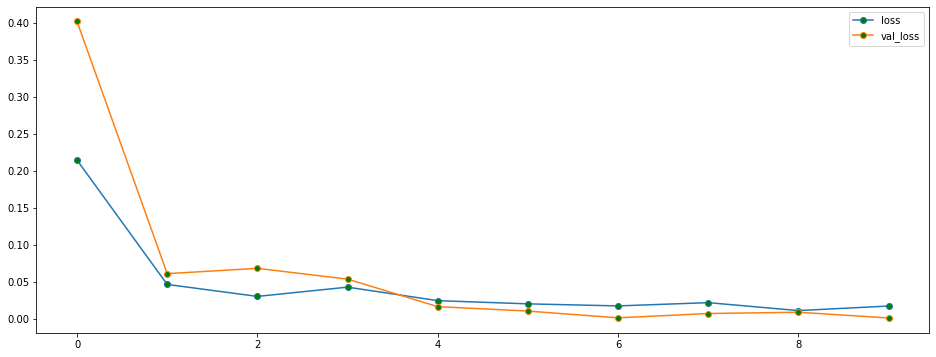

In [30]:
pd.DataFrame(history.history)[["loss","val_loss"]].plot(figsize=(16,6),marker="o",mfc="g")


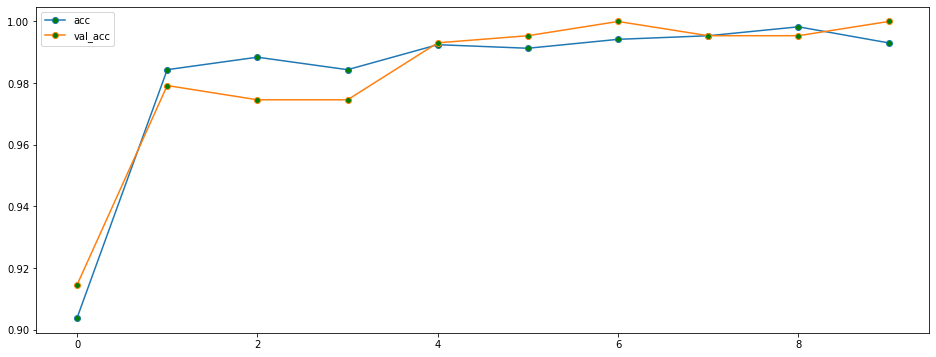

In [31]:
pd.DataFrame(history.history)[["acc","val_acc"]].plot(figsize=(16,6),marker="o",mfc="g")


In [33]:
from random import randint
random_indx = randint(1, len(os.listdir(TESTXRAY + "/COVID19")))
random_image_name_cov = os.listdir(TESTXRAY + "/COVID19")[random_indx]

random_indx_normal = randint(1, len(os.listdir(TESTXRAY + "/NORMAL") ))

random_image_name_normal = os.listdir(TESTXRAY + "/NORMAL") [random_indx_normal]
print(random_image_name_cov)
print(random_image_name_normal)

COVID19(504).jpg
NORMAL(1399).jpg


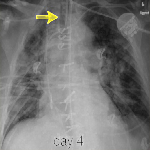

In [34]:
from tensorflow.keras.preprocessing import image
randCovImg = image.load_img(TESTXRAY + "/COVID19/"+random_image_name_cov,target_size=(150,150))
randNormImg = image.load_img(TESTXRAY + "/NORMAL/" + random_image_name_normal,target_size=(150,150))
randCovImg

In [39]:
random_covid_img_array = image.img_to_array(randCovImg)
random_normal_img_array = image.img_to_array(randNormImg)
def preprocess(img):
    img /= 255
    return img

random_covid_img_array = preprocess(random_covid_img_array)
random_normal_img_array = preprocess(random_normal_img_array)

covid_img_array = np.expand_dims(random_covid_img_array,axis=0)
normal_img_array = np.expand_dims(random_normal_img_array,axis=0)


print(xrayModel.predict(covid_img_array))
print(xrayModel.predict(normal_img_array))

[[0.0010508]]
[[1.]]


In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(xrayModel) # Your model's name
model = converter.convert()
file = open('/tmp/xray.tflite' , 'wb' ) 
file.write( model )

INFO:tensorflow:Assets written to: /tmp/tmp_618k67f/assets


INFO:tensorflow:Assets written to: /tmp/tmp_618k67f/assets


74565944